### Importing Libraries

In [49]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder , OneHotEncoder, StandardScaler , MinMaxScaler 
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold

from catboost import CatBoostRegressor
from sklearn.ensemble import AdaBoostRegressor ,GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression , ElasticNet , Ridge , Lasso
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
import tensorflow as tf
from tensorflow import keras

### Loading Data

In [50]:
data = pd.read_csv('train.csv')
data.head()

,id,gender,area,qualification,income,marital_status,vintage,claim_amount,num_policies,policy,type_of_policy,cltv
0,1,Male,Urban,Bachelor,5L-10L,1,5,5790,More than 1,A,Platinum,64308
1,2,Male,Rural,High School,5L-10L,0,8,5080,More than 1,A,Platinum,515400
2,3,Male,Urban,Bachelor,5L-10L,1,8,2599,More than 1,A,Platinum,64212
3,4,Female,Rural,High School,5L-10L,0,7,0,More than 1,A,Platinum,97920
4,5,Male,Urban,High School,More than 10L,1,6,3508,More than 1,A,Gold,59736


In [51]:
test_data = pd.read_csv('test.csv')
test_data.head()

,id,gender,area,qualification,income,marital_status,vintage,claim_amount,num_policies,policy,type_of_policy
0,89393,Female,Rural,High School,5L-10L,0,6,2134,More than 1,B,Silver
1,89394,Female,Urban,High School,2L-5L,0,4,4102,More than 1,A,Platinum
2,89395,Male,Rural,High School,5L-10L,1,7,2925,More than 1,B,Gold
3,89396,Female,Rural,Bachelor,More than 10L,1,2,0,More than 1,B,Silver
4,89397,Female,Urban,High School,2L-5L,0,5,14059,More than 1,B,Silver


In [52]:
data.describe()

,id,marital_status,vintage,claim_amount,cltv
count,89392.000000,89392.000000,89392.000000,89392.000000,89392.000000
mean,44696.500000,0.575488,4.595669,4351.502416,97952.828978
std,25805.391969,0.494272,2.290446,3262.359775,90613.814793
min,1.000000,0.000000,0.000000,0.000000,24828.000000
25%,22348.750000,0.000000,3.000000,2406.000000,52836.000000
50%,44696.500000,1.000000,5.000000,4089.000000,66396.000000
75%,67044.250000,1.000000,6.000000,6094.000000,103440.000000
max,89392.000000,1.000000,8.000000,31894.000000,724068.000000


In [53]:
data.describe(include = 'object')

,gender,area,qualification,income,num_policies,policy,type_of_policy
count,89392,89392,89392,89392,89392,89392,89392
unique,2,2,3,4,2,3,3
top,Male,Urban,High School,5L-10L,More than 1,A,Platinum
freq,50497,62455,46247,52716,60263,56644,47796


In [54]:
data.isnull().sum()

id                0
gender            0
area              0
qualification     0
income            0
marital_status    0
vintage           0
claim_amount      0
num_policies      0
policy            0
type_of_policy    0
cltv              0
dtype: int64

## Feature Engineering

In [55]:
data['income'] = data['income'].map({'5L-10L':'High','2L-5L':'Medium','More than 10L':'Very High','<=2L':'Low'})
test_data['income'] = test_data['income'].map({'5L-10L':'High','2L-5L':'Medium','More than 10L':'Very High','<=2L':'Low'})

data['income'].value_counts()

High         52716
Medium       21158
Very High    13664
Low           1854
Name: income, dtype: int64

In [56]:
data['num_policies'] = data['num_policies'].map({'More than 1':'>1','1':'1'})
test_data['num_policies'] = test_data['num_policies'].map({'More than 1':'>1','1':'1'})
data['num_policies'].value_counts()

>1    60263
1     29129
Name: num_policies, dtype: int64

In [57]:
cat_le = ['gender','area','policy']
cat_oe = ['qualification','income','type_of_policy','num_policies']

In [58]:
encoders = {}
for i in cat_le:
    encoders[i] = LabelEncoder()
    data[i] = encoders[i].fit_transform(data[i])
    test_data[i] = encoders[i].transform(test_data[i])

In [59]:
data = pd.concat([data,pd.get_dummies(data[cat_oe])],  axis = 1)
test_data = pd.concat([test_data,pd.get_dummies(test_data[cat_oe])],  axis = 1)

In [60]:
data.drop(cat_oe + ['id'] , axis = 1 , inplace = True)
test_data.drop(cat_oe + ['id'] , axis = 1 , inplace = True)

In [61]:
data.head()

,gender,area,marital_status,vintage,claim_amount,policy,cltv,qualification_Bachelor,qualification_High School,qualification_Others,income_High,income_Low,income_Medium,income_Very High,type_of_policy_Gold,type_of_policy_Platinum,type_of_policy_Silver,num_policies_1,num_policies_>1
0,1,1,1,5,5790,0,64308,1,0,0,1,0,0,0,0,1,0,0,1
1,1,0,0,8,5080,0,515400,0,1,0,1,0,0,0,0,1,0,0,1
2,1,1,1,8,2599,0,64212,1,0,0,1,0,0,0,0,1,0,0,1
3,0,0,0,7,0,0,97920,0,1,0,1,0,0,0,0,1,0,0,1
4,1,1,1,6,3508,0,59736,0,1,0,0,0,0,1,1,0,0,0,1


In [62]:
test_data.head()

,gender,area,marital_status,vintage,claim_amount,policy,qualification_Bachelor,qualification_High School,qualification_Others,income_High,income_Low,income_Medium,income_Very High,type_of_policy_Gold,type_of_policy_Platinum,type_of_policy_Silver,num_policies_1,num_policies_>1
0,0,0,0,6,2134,1,0,1,0,1,0,0,0,0,0,1,0,1
1,0,1,0,4,4102,0,0,1,0,0,0,1,0,0,1,0,0,1
2,1,0,1,7,2925,1,0,1,0,1,0,0,0,1,0,0,0,1
3,0,0,1,2,0,1,1,0,0,0,0,0,1,0,0,1,0,1
4,0,1,0,5,14059,1,0,1,0,0,0,1,0,0,0,1,0,1


In [63]:
X = data.drop('cltv',axis=1)
Y = data[['cltv']]
test_X = test_data.copy()

## Normalization

In [64]:
mm_x = MinMaxScaler()
X = mm_x.fit_transform(X)
test_X = mm_x.transform(test_X)

In [65]:
mm_y = MinMaxScaler()
Y = mm_y.fit_transform(Y)

## Model Selection

In [66]:
X_Train,X_Test,Y_Train,Y_Test = train_test_split(X , Y , test_size = 0.2 , random_state = 44)

In [67]:
GradientBoostingRegressor()

GradientBoostingRegressor()

In [68]:
models = [('XGR',XGBRegressor),('LR',LinearRegression),('CB',CatBoostRegressor)]

In [69]:
for name,model in models:
    if (name == 'CB'):
        model = model(logging_level='Silent')
    else:
        model = model()
    model.fit(X_Train,Y_Train.ravel())
    pred = model.predict(X_Test)
    error = r2_score(Y_Test , pred)
    print(f'{name} = {error}')

XGR = 0.1432704856077084
LR = 0.15030765603279794
CB = 0.15421563244014036


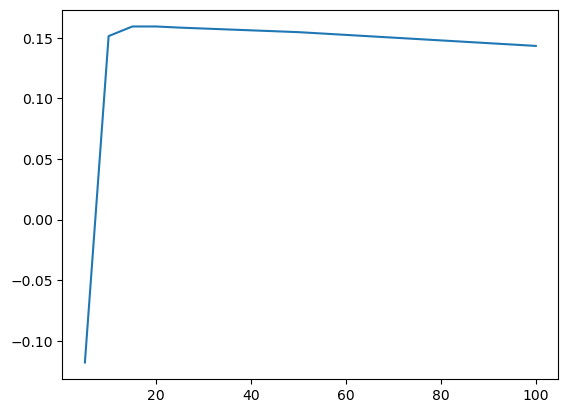

In [70]:
r2_scores= []
estimators = [5,10,15,20,25,50,100]
for est in estimators:
    xgr = XGBRegressor(n_estimators = est)
    xgr.fit(X_Train, Y_Train)

    pred = xgr.predict(X_Test)
    true = Y_Test
    score = r2_score(true , pred)
    r2_scores.append(score)
    
plt.plot(estimators ,  r2_scores)
plt.show()

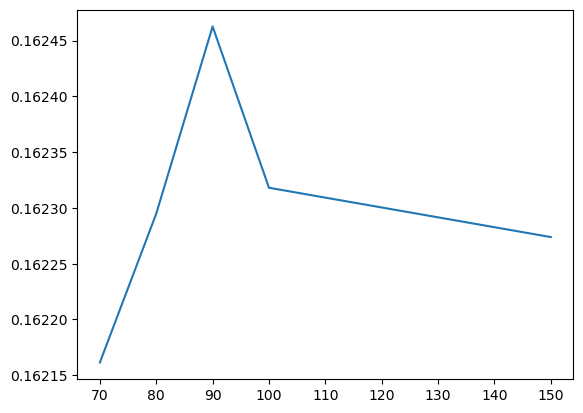

In [71]:
r2_scores= []
estimators = [70,80,90,100,150]
for est in estimators:
    cbr = CatBoostRegressor(n_estimators = est,depth= 6, learning_rate= 0.1,logging_level='Silent')
    cbr.fit(X_Train, Y_Train)

    pred = cbr.predict(X_Test)
    true = Y_Test
    score = r2_score(true , pred)
    r2_scores.append(score)
    
plt.plot(estimators ,  r2_scores)
plt.show()

### Hyperparameter Tuning

In [72]:
cbr = CatBoostRegressor(logging_level='Silent')

parameters = {'n_estimators': [10,50,70,80],
              'depth'  : [2,4,6],
                  'learning_rate' : [0.01, 0.1],
                 }

cat_grid = GridSearchCV(estimator=cbr,
                   param_grid=parameters,
                   scoring='r2', 
                   verbose=1)

cat_grid.fit(X_Train, Y_Train)

print(cat_grid.best_score_)
print(cat_grid.best_params_)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
ERROR! Session/line number was not unique in database. History logging moved to new session 2183
0.16014604372986616
{'depth': 4, 'learning_rate': 0.1, 'n_estimators': 80}


In [73]:
params = { 'max_depth': [3,6,9,12,15],
           'n_estimators': [10, 15,20]}

xgbr = XGBRegressor(seed = 4)
xgb_grid = GridSearchCV(estimator=xgbr, 
                   param_grid=params,
                   scoring='r2', 
                   verbose=1)

xgb_grid.fit(X_Train, Y_Train)

print(xgb_grid.best_score_)
print(xgb_grid.best_params_)

Fitting 5 folds for each of 15 candidates, totalling 75 fits
0.1592204673143262
{'max_depth': 3, 'n_estimators': 20}


## Cross Validation

In [74]:
k_fold = KFold(n_splits = 5)

r2_scores = []

for train_idx , test_idx in k_fold.split(X):  # KFOLDS returns index values
    X_Train = X[train_idx]
    Y_Train = Y[train_idx]
    
    X_Test = X[test_idx]
    Y_Test = Y[test_idx]    
    
    model = XGBRegressor(n_estimators = 20 , max_depth=3)
    model.fit(X_Train , Y_Train)
    pred = model.predict(X_Test)
    
    r2_scores.append(r2_score(Y_Test,pred))

r2_scores

[0.15981497168061587,
 0.1552347153722653,
 0.15644305324131513,
 0.1553185281371191,
 0.1729996923163073]

In [75]:
k_fold = KFold(n_splits = 5)

r2_scores = []

for train_idx , test_idx in k_fold.split(X):  # KFOLDS returns index values
    X_Train = X[train_idx]
    Y_Train = Y[train_idx]
    
    X_Test = X[test_idx]
    Y_Test = Y[test_idx]    
    
    model = CatBoostRegressor(depth= 6, learning_rate= 0.1, n_estimators= 75,logging_level='Silent')
    model.fit(X_Train , Y_Train)
    pred = model.predict(X_Test)
    
    r2_scores.append(r2_score(Y_Test,pred))

r2_scores

[0.16029490666941004,
 0.15629055523674007,
 0.15730839703188337,
 0.15546211351366868,
 0.17470134380873115]

## Prediction & Submission

In [76]:
test_preds = model.predict(test_X)
test_preds

array([0.10034842, 0.14928667, 0.10150924, ..., 0.11860446, 0.11616435,
       0.1299044 ])

In [77]:
test_preds = mm_y.inverse_transform(test_preds.reshape(-1, 1))
test_preds

array([[ 94995.63034803],
       [129215.21364034],
       [ 95807.32301462],
       ...,
       [107760.98178226],
       [106054.75813785],
       [115662.35065262]])

In [78]:
submission = pd.read_csv('sample_submission.csv')
submission.head()

,id,cltv
0,89393,97952.828978
1,89394,97952.828978
2,89395,97952.828978
3,89396,97952.828978
4,89397,97952.828978


In [79]:
test_data = pd.read_csv('test.csv')
test_data.head()

,id,gender,area,qualification,income,marital_status,vintage,claim_amount,num_policies,policy,type_of_policy
0,89393,Female,Rural,High School,5L-10L,0,6,2134,More than 1,B,Silver
1,89394,Female,Urban,High School,2L-5L,0,4,4102,More than 1,A,Platinum
2,89395,Male,Rural,High School,5L-10L,1,7,2925,More than 1,B,Gold
3,89396,Female,Rural,Bachelor,More than 10L,1,2,0,More than 1,B,Silver
4,89397,Female,Urban,High School,2L-5L,0,5,14059,More than 1,B,Silver


In [80]:
submission['cltv'] = test_preds
submission['id'] = test_data['id']
submission.head()

,id,cltv
0,89393,94995.630348
1,89394,129215.213640
2,89395,95807.323015
3,89396,88160.212940
4,89397,132715.266827


In [81]:
submission.to_csv("submission/sample_submission.csv",index=False)